# Setup Notebook (Virtual machine)

In this section all required packages will be installed.

In [83]:
!apt-get update
!apt-get install -y swig python3-numpy python3-dev cmake zlib1g-dev libjpeg-dev xvfb ffmpeg xorg-dev python3-opengl libboost-all-dev libsdl2-dev
!pip install gymnasium==0.29.0 gymnasium[box2d] pyvirtualdisplay imageio-ffmpeg moviepy==1.0.3
!pip install onnx onnx2pytorch==0.4.1
!pip install opencv-python pyvirtualdisplay

!wget https://raw.githubusercontent.com/StefOe/colab-pytorch-utils/master/utils.py
import utils


!pip install minigrid==2.0.0

Der Befehl "apt-get" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.
Der Befehl "apt-get" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


Der Befehl "wget" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


In [84]:
import time
from datetime import datetime
import numpy as np
from collections import deque, namedtuple
import collections
import os
import time
import shutil
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import cv2
import gymnasium as gym
import gymnasium.spaces

import matplotlib.pyplot as plt
import copy
%matplotlib inline
!nvcc --version

from matplotlib import animation
import seaborn as sns; sns.set()
from IPython.display import clear_output, HTML
from IPython import display

import torch.onnx

Der Befehl "nvcc" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


# Mount your drive and use GPU

Here you can mount your GDrive folders (where you will store checkpoints during training).

In [85]:
# if not os.path.exists('/content/gdrive'):
#     from google.colab import drive
#     drive.mount('/content/gdrive')

In [86]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Replay Buffer

The replay buffer stores transitions - state, action, reward, next_state.

In [87]:
Transition = namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])

class ReplayBuffer():
  def __init__(self, num_actions, memory_len = 10000):
      self.memory_len = memory_len
      self.transition = []
      self.num_actions = num_actions

  def add(self, state, action, reward, next_state, done):
      if self.length() > self.memory_len:
        self.remove()
      self.transition.append(Transition(state, action, reward, next_state, done))

  def sample_batch(self, batch_size = 32):
      minibatch = random.sample(self.transition, batch_size)
      states_mb, a_, reward_mb, next_states_mb, done_mb = map(np.array, zip(*minibatch))

      mb_reward = torch.from_numpy(reward_mb).to(device=device, dtype=torch.float32)
      mb_done = torch.from_numpy(done_mb.astype(int)).to(device=device)
      a_ = a_.astype(int)
      a_mb = np.zeros((a_.size, self.num_actions), dtype=np.float32)
      a_mb[np.arange(a_.size), a_] = 1
      mb_a = torch.from_numpy(a_mb).cuda().to(device=device)
      return states_mb, mb_a, mb_reward, next_states_mb, mb_done # states will be converted to tensors in forward pass

  def length(self):
      return len(self.transition)

  def remove(self):
      self.transition.pop(0)

# MINIGRID DQN-Training

This section contains the train function for the minigrid environment.

### Minigrid Environment and Policy Network





In [88]:
# Minigrid Environment
from minigrid.wrappers import ImgObsWrapper
class ChannelFirst(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        old_shape = env.observation_space.shape
        self.observation_space = {}
        self.observation_space = gym.spaces.Box(0, 255, shape=(3, 7, 7))

    def observation(self, observation):
        return np.swapaxes(observation, 2, 0)

class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)

    def observation(self, observation):
        # careful! This undoes the memory optimization, use
        # with smaller replay buffers only.
        return np.array(observation).astype(np.float32)

class MinigridEmpty5x5ImgObs(gym.Wrapper):
    """Minigrid with image observations provided by minigrid, partially observable."""
    def __init__(self, render=False):
        if render:
          env = gym.make('MiniGrid-Empty-5x5-v0', render_mode="rgb_array")
        else:
          env = gym.make('MiniGrid-Empty-5x5-v0')
        env = ScaledFloatFrame(ChannelFirst(ImgObsWrapper(env)))
        super().__init__(env)

class MinigridDoorKey6x6ImgObs(gym.Wrapper):
    """Minigrid with image observations provided by minigrid, partially observable."""
    def __init__(self, render=False):
        if render:
          env = gym.make('MiniGrid-DoorKey-6x6-v0', render_mode="rgb_array")
        else:
          env = gym.make('MiniGrid-DoorKey-6x6-v0')
        env = ScaledFloatFrame(ChannelFirst(ImgObsWrapper(env)))
        super().__init__(env)

In [89]:
env = MinigridDoorKey6x6ImgObs()
obs = env.reset()[0]
obs, obs.shape, env.action_space

(array([[[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [2., 2., 2., 2., 2., 0., 0.],
         [2., 5., 1., 1., 2., 0., 0.]],
 
        [[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [5., 5., 5., 5., 5., 0., 0.],
         [5., 4., 0., 0., 5., 0., 0.]],
 
        [[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.]]], dtype=float32),
 (3, 7, 7),
 Discrete(7))

In [90]:
class MlpMinigridPolicy(nn.Module):
    def __init__(self, num_actions=7):
        super().__init__()
        self.num_actions = num_actions
        self.fc = nn.Sequential(nn.Flatten(),
                                nn.Linear(3*7**2, 256), nn.ReLU(),
                                nn.Linear(256, 256), nn.ReLU(),
                                nn.Linear(256, 64), nn.ReLU(),
                                nn.Linear(64, num_actions))
    def forward(self, x):
        if len(x.size()) == 3:
          x = x.unsqueeze(dim=0)
        return self.fc(x)

### Training utils

In [91]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

In [92]:
def set_seed(env, seed=None):
    if seed is not None:
        random.seed(seed)
        env.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)


In [93]:
num_episodes = 1000 # number of episodes to run the algorithm -> the algorithm should reach a score of about 0.9 within 1000 episodes
buffer_size = 500000 # size of the buffer to use
epsilon = 1.0 # initial probablity of selecting random action a, annealed over time
timesteps = 0 # counter for number of frames
minibatch_size = 256 #128 # size of the minibatch sampled
gamma = 0.99 # discount factor
eval_episode = 100
num_eval = 10
tau = 1e-3
learning_rate = 0.00001
update_after = 2000 # update after num time steps
epsilon_decay = 100000 # decay epsilon in 100.000 timesteps
epsilon_ub = 1.0
epsilon_lb = 0.3
# set seed
np.random.seed(0)
torch.manual_seed(0)

In [94]:
print(device)

cuda


### Load model (if available)

In [95]:
# specify load path if available:

load_path = '' # otherwise start with randomly initialized agent

# save the current model state
save_path = f"Assignment 2/Model/minigrid-model-{datetime.now().strftime('%Y_%m_%d-%H_%M_%S')}.p"
# save_path = f"minigrid-model-{datetime.now().strftime('%Y_%m_%d-%H_%M_%S')}.p"

print(f'model checkpoints will be saved to: {save_path}')

def load_checkpoint(checkpoint_path='', device=device):
  dqn = MlpMinigridPolicy(num_actions=num_actions).to(device=device)
  dqn_target = MlpMinigridPolicy(num_actions=num_actions).to(device=device)
  timesteps = 0

  if checkpoint_path and os.path.isfile(checkpoint_path):
    print(f'Loading checkpoint {checkpoint_path}')
    checkpoint_dict = torch.load(checkpoint_path, map_location=device)
    model_params = checkpoint_dict['model_params']
    timesteps = checkpoint_dict['timesteps'] # environment steps

    dqn.load_state_dict(model_params) # makes a copy of model_params
    dqn_target.load_state_dict(model_params)
  else:
    print(f'Starting training from scratch.')

  return dqn, dqn_target, timesteps

def store_checkpoint(checkpoint_path, dqn_net, timesteps):
  checkpoint_dict = {'model_params':dqn_net.state_dict(), 'timesteps': timesteps}
  torch.save(checkpoint_dict, checkpoint_path)

model checkpoints will be saved to: C:/Users/Q540900/Desktop/A.I. Master/Second Semester/Deep Reinforcement/Assignment 2/Model/minigrid-model-2024_05_13-14_17_58.p


In [96]:
# Initialize environment

# VERY IMPORTANT:
# Fast environment to build your code: MinigridEmpty5x5ImgObs() <- Train on this to improve your code fast.
# Actual environment for the exercise: MinigridDoorKey6x6ImgObs() <- Train on this for submitting on challenge server.
# Make sure to train on the right environment, when you are submitting your model.

env = MinigridDoorKey6x6ImgObs()

num_actions = env.action_space.n
state_space = env.observation_space.shape
print(num_actions, state_space)
obs, obs.shape, env.action_space

7 (3, 7, 7)


(array([[[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [2., 2., 2., 2., 2., 0., 0.],
         [2., 5., 1., 1., 2., 0., 0.]],
 
        [[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [5., 5., 5., 5., 5., 0., 0.],
         [5., 4., 0., 0., 5., 0., 0.]],
 
        [[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.]]], dtype=float32),
 (3, 7, 7),
 Discrete(7))

In [97]:
# Update Target network
def soft_update(local_model, target_model, tau):
    """Soft update model parameters.
    θ_target = τ*θ_local + (1 - τ)*θ_target
    Params
    ======
        local_model (PyTorch model): weights will be copied from
        target_model (PyTorch model): weights will be copied to
        tau (float): interpolation parameter
    """
    # TODO: Update target network
    # ....

    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
        target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)

### DQN training loop

In [98]:
from torch.serialization import load

# Train the agent using DQN for Pong
returns = []
returns_50 = deque(maxlen=50)
losses = []
buffer = ReplayBuffer(num_actions=num_actions, memory_len=buffer_size)

dqn, dqn_target, timesteps = load_checkpoint(load_path)

optimizer = optim.Adam(dqn.parameters(), lr=learning_rate)
mse = torch.nn.MSELoss()
state = env.reset()[0]
for i in range(num_episodes):
  ret = 0
  done = False
  while not done:
    # Decay epsilon
    epsilon = max(epsilon_lb, epsilon_ub - timesteps/ epsilon_decay)
    # action selection
    if np.random.choice([0,1], p=[1-epsilon,epsilon]) == 1:
      a = np.random.randint(low=0, high=num_actions, size=1)[0]
    else:
      # state_tmp = state[np.newaxis, :].astype(np.float32)
      state_tensor = torch.tensor(state, dtype=torch.float32, device=device)
      net_out = dqn(state_tensor).detach().cpu().numpy()
      a = np.argmax(net_out)
#    next_state, r, done, info = env.step(a)
    next_state, r, terminated, truncated, info = env.step(a)
    done = terminated or truncated
#    print(next_state.shape)
    ret = ret + r
    # TODO: store transition in replay buffer
    # ....
    buffer.add(state=state, action=a, reward=r, next_state=next_state, done=done)
    # ....
    state = next_state
    timesteps = timesteps + 1

    # update policy using temporal difference
    if buffer.length() > minibatch_size and buffer.length() > update_after:
      optimizer.zero_grad()
      # TODO: Sample a minibatch randomly
      states_mb, a_mb, reward_mb, next_states_mb, done_mb = buffer.sample_batch(minibatch_size)
      # ....
      # TODO: Compute q values for states
      states_tensor = torch.tensor(states_mb, dtype=torch.float32, device=device)
      next_states_tensor = torch.tensor(next_states_mb, dtype=torch.float32, device=device)
      q_values = dqn(states_tensor)
      # ....
      # ....
      # TODO: compute the targets for training
      # ....
      next_q_values = dqn(next_states_tensor)
      next_actions = torch.argmax(next_q_values, dim=1)
      target_q_values = dqn_target(next_states_tensor)
      max_next_q_values = target_q_values.gather(1, next_actions.unsqueeze(-1)).squeeze(-1)
      targets = reward_mb + (1 - done_mb) * gamma * max_next_q_values

      # TODO: compute the predictions for training
      # ....
      predictions = torch.sum(q_values * a_mb, dim=1)
      # TODO: Compute loss: mse = mean squared error
      # ....
      loss = mse(predictions, targets)
      # print('predictions', predictions, 'targets', targets)
      # print(loss)
      loss.backward()
      optimizer.step()
      losses.append(loss.item())

      # Update target network
      soft_update(dqn, dqn_target, tau)
    if done:
      state = env.reset()[0]
      print(f"Episode: \t{i}\t{ret}\t{datetime.now().strftime('%Y_%m_%d-%H_%M_%S')}")
      break
  returns.append(ret)
  returns_50.append(ret)
  if i % 50 == 0:
    store_checkpoint(checkpoint_path=save_path, dqn_net=dqn, timesteps=timesteps)
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i, np.mean(returns_50)))

Starting training from scratch.
Episode: 	0	0	2024_05_13-14_17_58
Episode 0	Average Score: 0.00
Episode: 	1	0.8848	2024_05_13-14_17_58
Episode: 	2	0	2024_05_13-14_17_58
Episode: 	3	0	2024_05_13-14_17_58
Episode: 	4	0	2024_05_13-14_17_58
Episode: 	5	0	2024_05_13-14_17_58
Episode: 	6	0	2024_05_13-14_17_59
Episode: 	7	0	2024_05_13-14_17_59
Episode: 	8	0.5247999999999999	2024_05_13-14_17_59
Episode: 	9	0	2024_05_13-14_17_59
Episode: 	10	0	2024_05_13-14_18_00
Episode: 	11	0	2024_05_13-14_18_01
Episode: 	12	0	2024_05_13-14_18_02
Episode: 	13	0	2024_05_13-14_18_03
Episode: 	14	0	2024_05_13-14_18_04
Episode: 	15	0	2024_05_13-14_18_05
Episode: 	16	0	2024_05_13-14_18_06
Episode: 	17	0	2024_05_13-14_18_07
Episode: 	18	0	2024_05_13-14_18_09
Episode: 	19	0	2024_05_13-14_18_10
Episode: 	20	0	2024_05_13-14_18_11
Episode: 	21	0.4708	2024_05_13-14_18_12
Episode: 	22	0	2024_05_13-14_18_13
Episode: 	23	0	2024_05_13-14_18_14
Episode: 	24	0	2024_05_13-14_18_15
Episode: 	25	0	2024_05_13-14_18_16
Episode: 	2

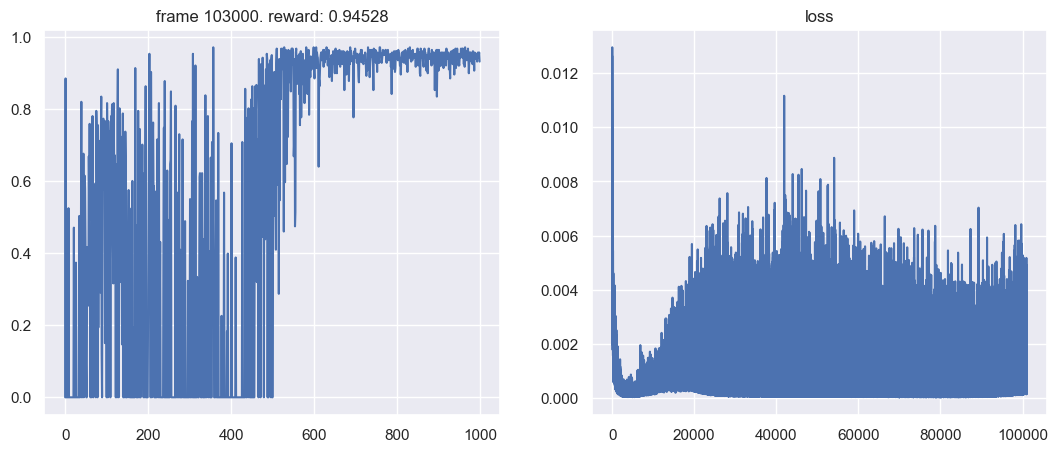

In [99]:
plot(timesteps, returns, losses)

Evaluate your model:

In [100]:
class Agent():
    def __init__(self, model, device):
        self.model = model
        self.device = device

    def select_action(self, state):
        state = np.expand_dims(state, 0)
        state = torch.tensor(state, dtype=torch.float32, device=self.device)
        with torch.no_grad():
            q_action = self.model(state).detach().cpu().numpy()

            return np.argmax(q_action)

def run_episode(env, agent, seed=None):
    state = env.reset(seed=seed)[0]
    score = 0
    done = False
    while not done:
        action = agent.select_action(state)
        state, reward, terminated, truncated, _ = env.step(action)
        score += reward
        done = terminated or truncated
    env.close()
    return score

In [101]:
N_EPISODES = 50
agent = Agent(model=dqn, device=device)

scores = []
for i in range(N_EPISODES):
    seed = np.random.randint(1e7)
    scores.append(run_episode(env, agent, seed=seed))

# Print result
print("Average Return:", np.mean(scores))

Average Return: 0.9649359999999999


Convert model to ONNX for Submission:

In [102]:
def save_as_onnx(torch_model, sample_input, model_path):
    torch.onnx.export(torch_model,             # model being run
                    sample_input,              # model input (or a tuple for multiple inputs)
                    f=model_path,              # where to save the model (can be a file or file-like object)
                    export_params=True,        # store the trained parameter weights inside the model file
                    opset_version=17,          # the ONNX version to export the model to - see https://github.com/microsoft/onnxruntime/blob/master/docs/Versioning.md
                    do_constant_folding=True,  # whether to execute constant folding for optimization
                    )

In [103]:
sample_state = env.reset(seed=seed)[0]
save_as_onnx(dqn, torch.tensor(sample_state, dtype=torch.float32, device=device), 'submission_model_new.onnx')

In [104]:
# load the onnx model and test it:
import onnx
from onnx2pytorch import ConvertModel

N_EPISODES = 50

dqn = ConvertModel(onnx.load('submission_model_new.onnx'))
dqn = dqn.to(device)
dqn.eval()

agent = Agent(model=dqn, device=device)

scores = []
for i in range(N_EPISODES):
    seed = np.random.randint(1e7)
    scores.append(run_episode(env, agent, seed=seed))


print("Average Return:", np.mean(scores))

Average Return: 0.9635679999999998
